#### Initating the Random Forest Model

In [536]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score, accuracy_score,f1_score, precision_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns

In [537]:
import pandas as pd
ml_deepak = pd.read_csv("gold_df.csv")
df = ml_deepak.copy()

In [538]:
unique_venues = df['venue'].nunique()
print(f"Total number of unique venues IPL matches were played at: {unique_venues}")

Total number of unique venues IPL matches were played at: 41


In [539]:
df.shape
df.describe()
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256796 entries, 0 to 256795
Data columns (total 34 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        256796 non-null  int64  
 1   inning            256796 non-null  int64  
 2   batting_team      256796 non-null  object 
 3   bowling_team      256796 non-null  object 
 4   over              256796 non-null  int64  
 5   ball              256796 non-null  int64  
 6   batter            256796 non-null  object 
 7   bowler            256796 non-null  object 
 8   non_striker       256796 non-null  object 
 9   batsman_runs      256796 non-null  int64  
 10  extra_runs        256796 non-null  int64  
 11  total_runs        256796 non-null  int64  
 12  extras_type       256796 non-null  object 
 13  is_wicket         256796 non-null  int64  
 14  player_dismissed  256796 non-null  object 
 15  dismissal_kind    256796 non-null  object 
 16  id                25

#### Initial Approach for Predicting the match winner

In [540]:
# Data for model training
# Keeing only the necessary columns
columns_to_keep = ["winner", "team1", "team2", "city", "venue"]
df_bmp = df[columns_to_keep]
df_bmp = df_bmp.dropna()


In [541]:
#describing the before match prediction data
df_bmp.shape
df_bmp.describe()
df_bmp.count()
df_bmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256796 entries, 0 to 256795
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   winner  256796 non-null  object
 1   team1   256796 non-null  object
 2   team2   256796 non-null  object
 3   city    256796 non-null  object
 4   venue   256796 non-null  object
dtypes: object(5)
memory usage: 9.8+ MB


In [542]:
#Feature Selection and Encoding 
features = ["team1", "team2", "city", "venue"]
target = "winner"

# Drop missing and make a copy
df_model = df_bmp[features + [target]].dropna().copy()


In [543]:
#Encoding categorical variables
label_encoders = {}
for col in df_model.columns:
    if df_model[col].dtype == 'object':
        le = LabelEncoder()
        df_model[col] = le.fit_transform(df_model[col])
        label_encoders[col] = le


   Train Size  Test Size  Accuracy
0         0.9        0.1     80.17
1         0.8        0.2     80.20
2         0.7        0.3     79.99
3         0.6        0.4     79.99


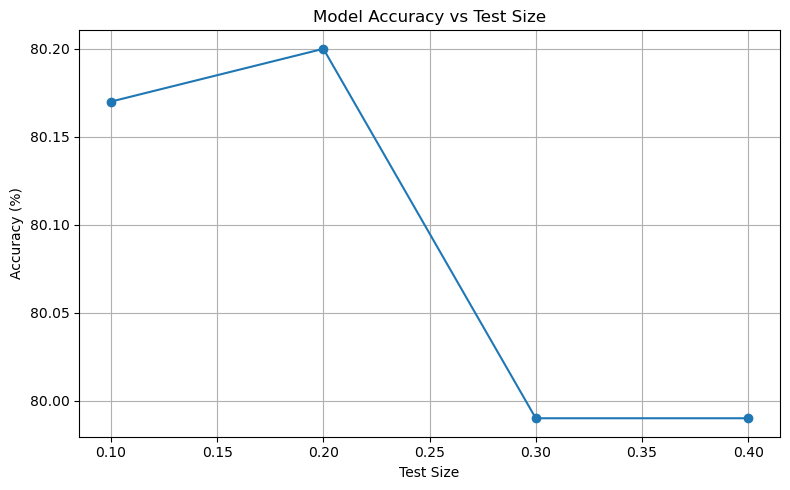

In [544]:
# Splitting the data into training and testing sets
# Split features and target
X = df_model[features]
y = df_model[target]

# Define test size range
test_sizes = [0.1, 0.2, 0.3, 0.4]
results = []

# Train and evaluate model on different test sizes
for test_size in test_sizes:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    results.append({
        "Train Size": round(1 - test_size, 2),
        "Test Size": test_size,
        "Accuracy": round(acc * 100, 2)
    })

    # Convert results to DataFrame
results_df = pd.DataFrame(results)
print(results_df)

# Plotting the results
# Plot the accuracy vs test size
plt.figure(figsize=(8, 5))
plt.plot(results_df["Test Size"], results_df["Accuracy"], marker='o')
plt.title("Model Accuracy vs Test Size")
plt.xlabel("Test Size")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.tight_layout()
plt.show()


Best test size: 0.2 with Accuracy: 80.2%


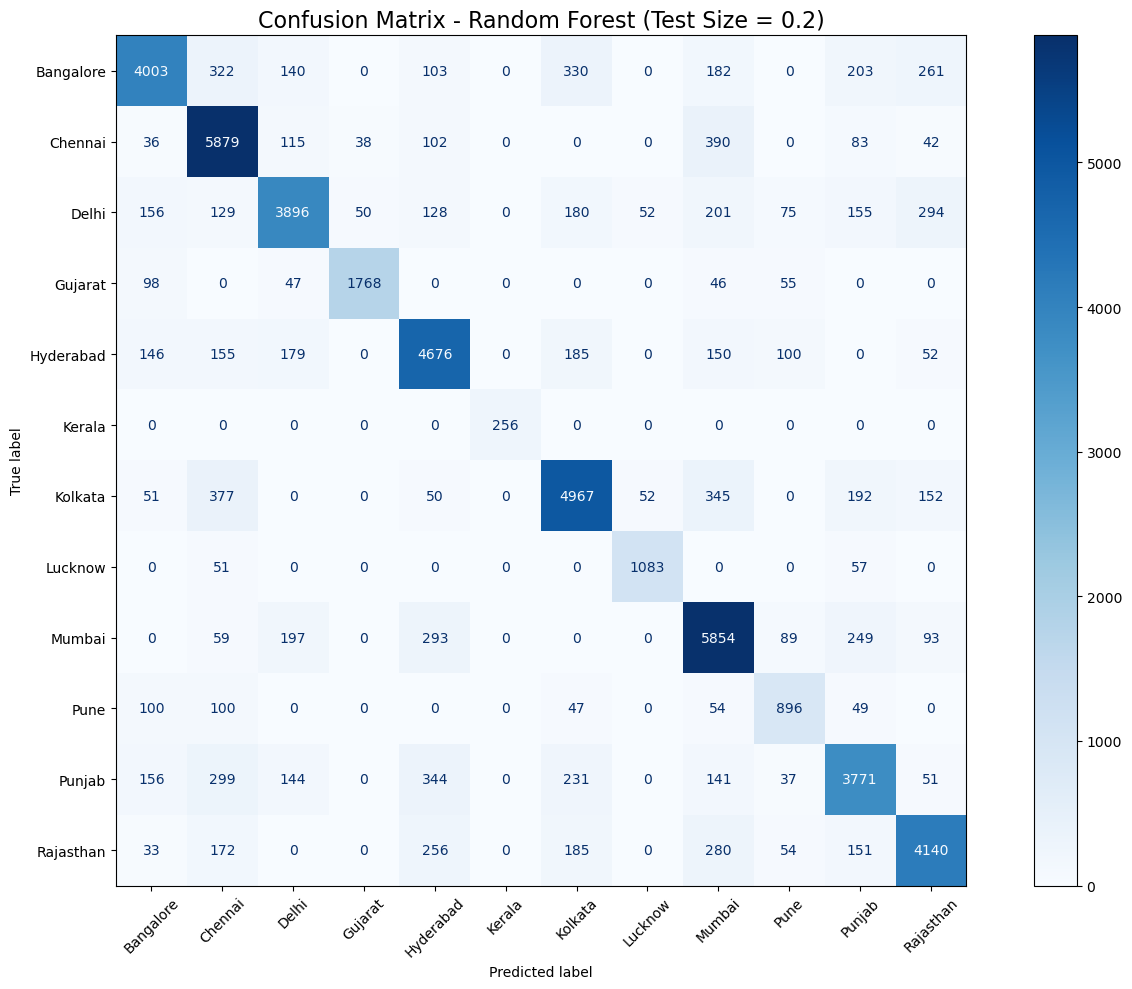

In [545]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Step 1: Find best split based on Accuracy
best_split = max(results, key=lambda x: x['Accuracy'])
best_test_size = best_split["Test Size"]
print(f"\nBest test size: {best_test_size} with Accuracy: {best_split['Accuracy']}%")

# Step 2: Re-train model on best split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=best_test_size, random_state=42)
best_model = RandomForestClassifier(n_estimators=100, random_state=42)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# Step 3: Plot the Confusion Matrix
#cm = confusion_matrix(y_test, y_pred)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
target_names = label_encoders[target].classes_
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)

fig, ax = plt.subplots(figsize=(14, 10))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45, values_format='.0f')
plt.title(f"Confusion Matrix - Random Forest (Test Size = {best_test_size})", fontsize=16)
plt.grid(False)
plt.tight_layout()
plt.show()


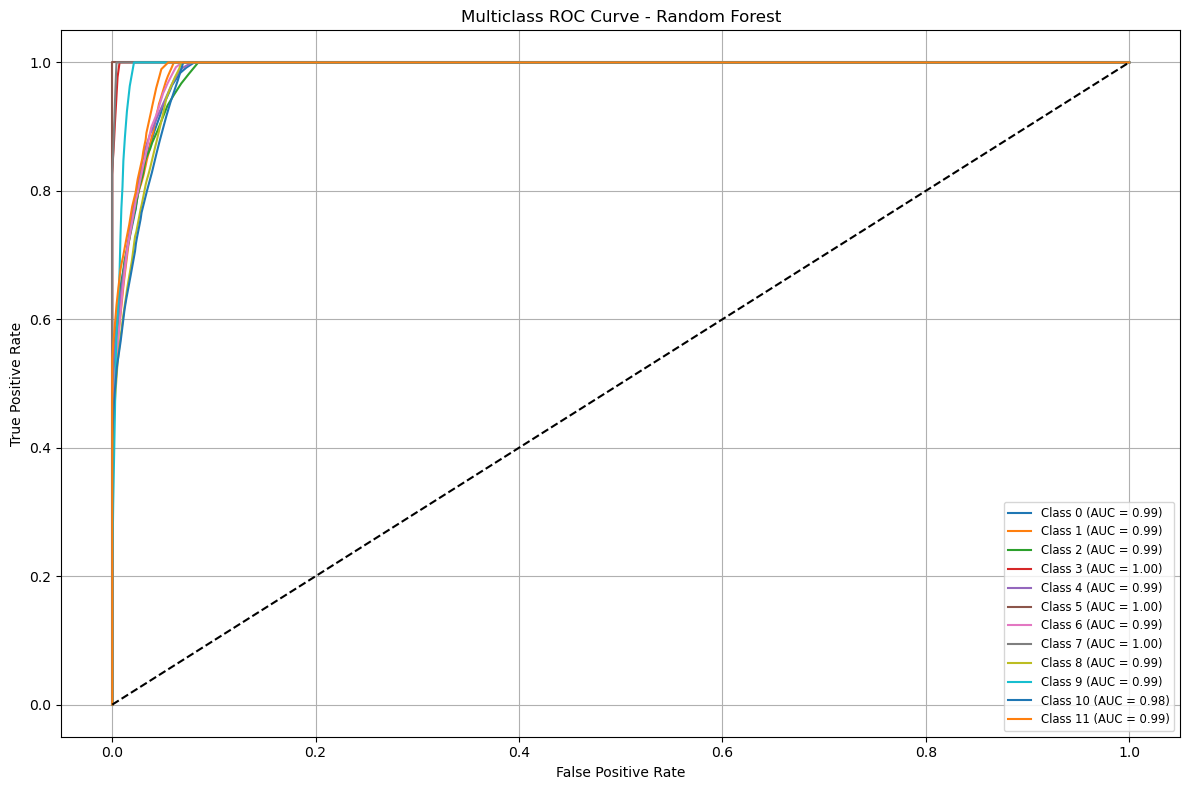

In [546]:
#ROC Curve
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import numpy as np

# Binarize the true labels for multiclass ROC
y_test_bin = label_binarize(y_test, classes=np.unique(y))
y_score = model.predict_proba(X_test)

fpr = {}
tpr = {}
roc_auc = {}

plt.figure(figsize=(12, 8))
for i in range(y_score.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title("Multiclass ROC Curve - Random Forest")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right", fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()


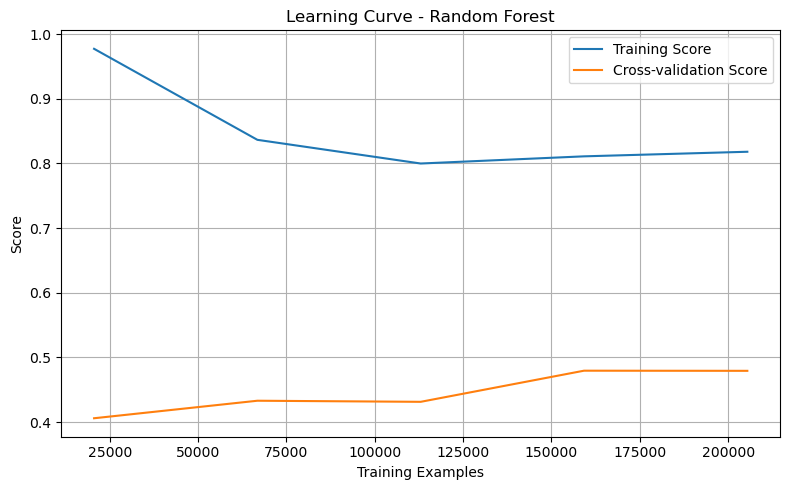

In [547]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    model, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_scores_mean, label="Training Score")
plt.plot(train_sizes, test_scores_mean, label="Cross-validation Score")
plt.title("Learning Curve - Random Forest")
plt.xlabel("Training Examples")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [548]:
#Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.72      0.78      5544
           1       0.78      0.88      0.83      6685
           2       0.83      0.73      0.78      5316
           3       0.95      0.88      0.91      2014
           4       0.79      0.83      0.81      5643
           5       1.00      1.00      1.00       256
           6       0.81      0.80      0.81      6186
           7       0.91      0.91      0.91      1191
           8       0.77      0.86      0.81      6834
           9       0.69      0.72      0.70      1246
          10       0.77      0.73      0.75      5174
          11       0.81      0.79      0.80      5271

    accuracy                           0.80     51360
   macro avg       0.83      0.82      0.82     51360
weighted avg       0.80      0.80      0.80     51360



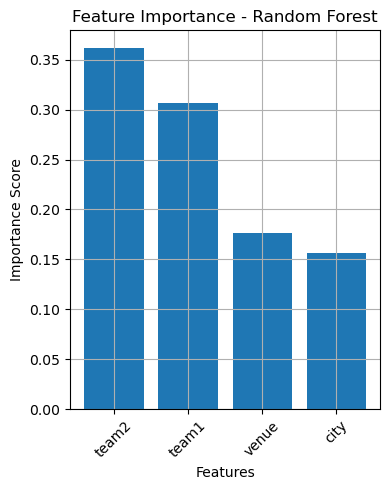

In [549]:
# Feature Importance Plot
import matplotlib.pyplot as plt
import pandas as pd

# Feature names (used during training)
feature_names = ["team1", "team2", "city", "venue"]

# Get feature importances from the trained model
importances = best_model.feature_importances_
indices = importances.argsort()[::-1]

# Plot
plt.figure(figsize=(4, 5))
plt.bar(range(len(feature_names)), importances[indices], align="center")
plt.xticks(range(len(feature_names)), [feature_names[i] for i in indices], rotation=45)
plt.title("Feature Importance - Random Forest")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.grid(True)
plt.tight_layout()
plt.show()


#### Hyper-Parameter tuning the initail Approach model

In [550]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score
import time

# Sample a manageable subset (e.g., 50K for tuning)
X_sample, _, y_sample, _ = train_test_split(X, y, train_size=50000, stratify=y, random_state=42)

# Use 80/30 split on the sample
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42)

# Hyperparameter grid
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Randomized Search
rf = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=30,
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=42,
    scoring='accuracy'
)

# Run the search
start = time.time()
random_search.fit(X_train, y_train)
end = time.time()

# Results
print(f"\n RandomizedSearchCV completed in {round((end - start) / 60, 2)} minutes")
print("Best Parameters:", random_search.best_params_)

best_rf = random_search.best_estimator_
y_pred = best_rf.predict(X_test)

print("\n Classification Report:")
print(classification_report(y_test, y_pred))
print(f" Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")


Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_est


 #### Why diffferent approach? 
 #### the initial random forest model suffered from data leakage, resulting in unrealistically high accuracy scores.  

##### Building a Robust Model:To address this, the dataset was aggregated at the match level. Instead of using the original gold_df, a new, appropriately structured DataFrame is referenced to ensure a more robust modeling process.

##### Limitation of the Initial Model: The initial model was misleading—not only did it display inflated accuracy, but it also attempted to predict the winning team from all possible teams, rather than focusing on the specific teams playing each match. This approach did not align with our actual business requirement.



#### Random Forest Classifier - Binary classification Approach

##### if Team1 win == 1 else == 0, 0 to be considered as Team2 as winner of the match, and introduced a new target column

In [551]:
df = pd.read_csv('aggregated_match_data_by_innings_wo_small_dataset.csv')
df = df[(df['winner'] == df['team1']) | (df['winner'] == df['team2'])]
df['target_binary'] = (df['winner'] == df['team1']).astype(int)

X = df[['season', 'city', 'venue', 'toss_winner', 'toss_decision', 'team1', 'team2',
        'inning1_runs', 'inning1_wickets', 'inning1_balls']]
X = pd.get_dummies(X)
y = df['target_binary']

In [552]:
#Trainig the model in different test sizes

test_sizes = [0.1, 0.2, 0.3, 0.4]
split_results = []

for test_size in test_sizes:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=42
    )
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Test size: {test_size:.2f}, Accuracy: {acc * 100:.2f}%")
    split_results.append((test_size, acc))

Test size: 0.10, Accuracy: 59.09%
Test size: 0.20, Accuracy: 62.50%
Test size: 0.30, Accuracy: 56.82%
Test size: 0.40, Accuracy: 57.67%


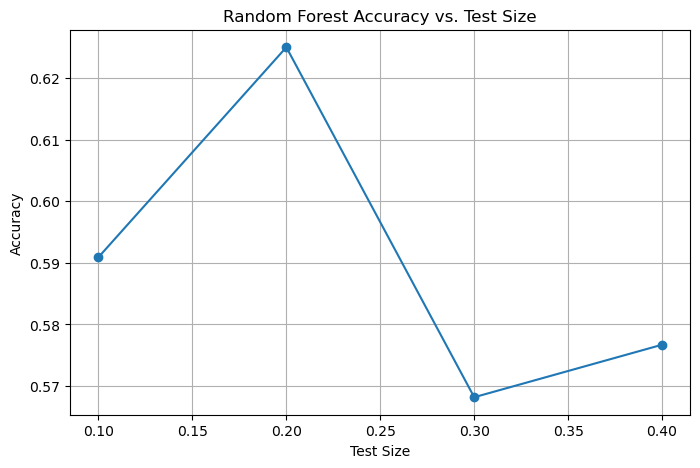

In [553]:
#Plot accuracy vs test sizes
split_results_df = pd.DataFrame(split_results, columns=["Test Size", "Accuracy"])
plt.figure(figsize=(8,5))
plt.plot(split_results_df["Test Size"], split_results_df["Accuracy"], marker='o')
plt.title("Random Forest Accuracy vs. Test Size")
plt.xlabel("Test Size")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

In [554]:
#Plotting the Confusion Matrix for the best test size
chosen_test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=chosen_test_size, stratify=y, random_state=42
)
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

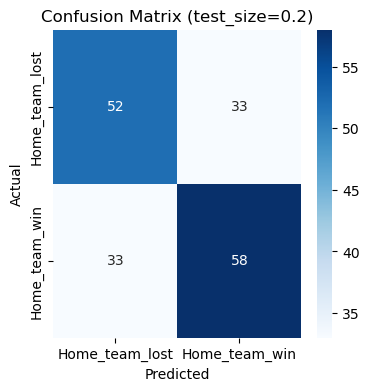

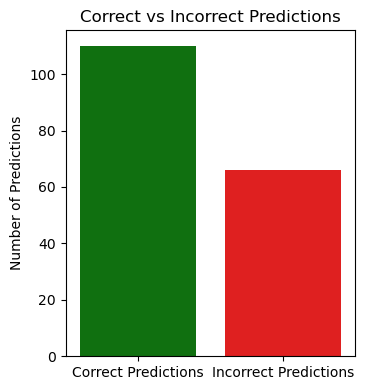

In [555]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Home_team_lost', 'Home_team_win'], yticklabels=['Home_team_lost', 'Home_team_win'])
plt.title(f"Confusion Matrix (test_size={chosen_test_size})")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#Correct vs Incorrect Predictions
tn, fp, fn, tp = cm.ravel()
correct = tp + tn
incorrect = fp + fn
# Plot bar chart
plt.figure(figsize=(3.75, 4))
sns.barplot(x=["Correct Predictions", "Incorrect Predictions"], y=[correct, incorrect], palette=["green", "red"])
plt.title("Correct vs Incorrect Predictions")
plt.ylabel("Number of Predictions")
plt.tight_layout()
plt.show()


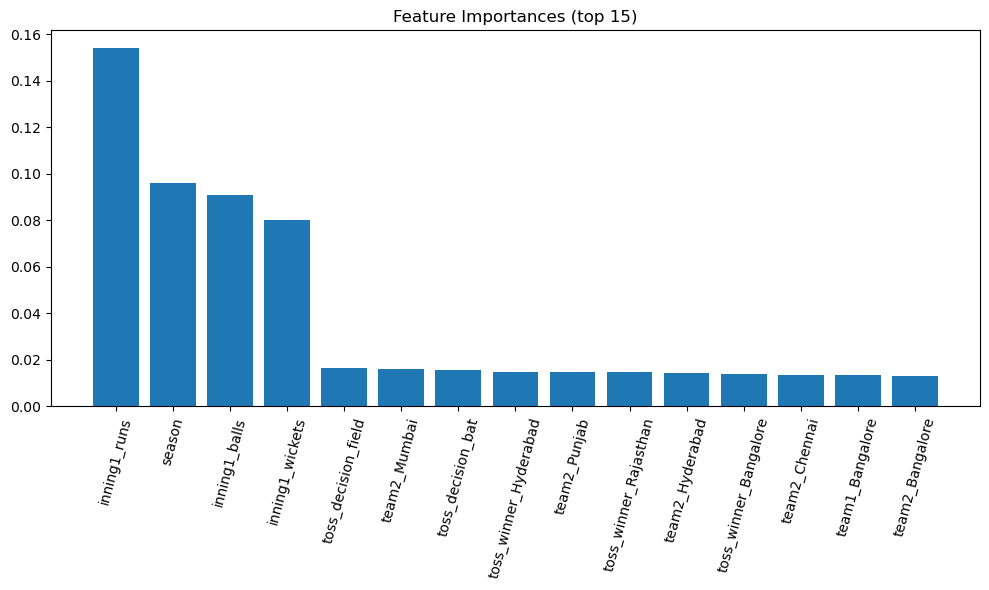

In [556]:
# 3. Feature importance
importances = rf.feature_importances_
indices = importances.argsort()[::-1]
feature_names = X.columns

plt.figure(figsize=(10,6))
plt.title("Feature Importances (top 15)")
plt.bar(range(15), importances[indices][:15], align="center")
plt.xticks(range(15), [feature_names[i] for i in indices[:15]], rotation=75)
plt.tight_layout()
plt.show()


                precision  recall  f1-score  support
Home_team_lost      0.612   0.612     0.612   85.000
Home_team_win       0.637   0.637     0.637   91.000
accuracy            0.625   0.625     0.625    0.625
macro avg           0.625   0.625     0.625  176.000
weighted avg        0.625   0.625     0.625  176.000


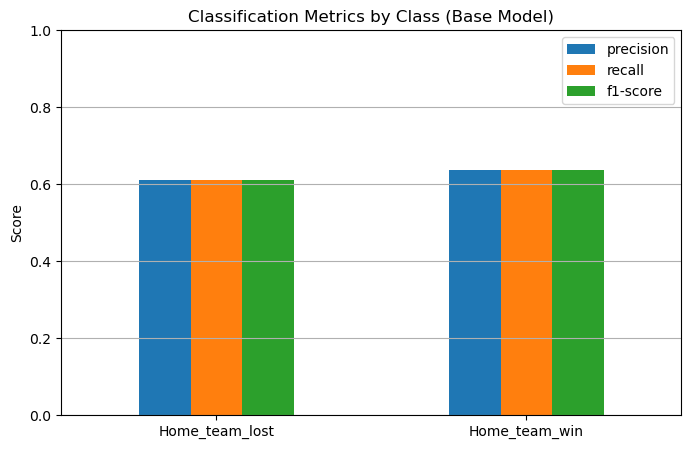

In [557]:
#Classification report
report = classification_report(y_test, y_pred, target_names=['Home_team_lost', 'Home_team_win'], output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df = report_df.round(3)
# Show as table
print(report_df)
report_df

plot_df = report_df.loc[['Home_team_lost', 'Home_team_win'], ['precision', 'recall', 'f1-score']]
plot_df.plot(kind='bar', figsize=(8, 5))
plt.title('Classification Metrics by Class (Base Model)')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()



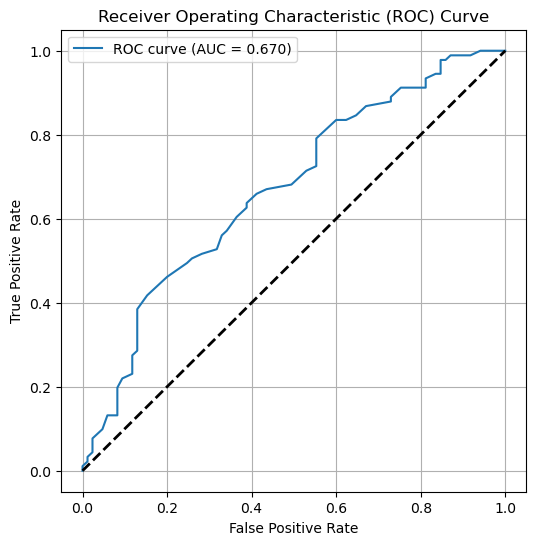

In [558]:
# Probabilities for the positive class (team1_win, which is 1)
y_proba = rf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0,1], [0,1], 'k--', lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.grid(True)
plt.show()

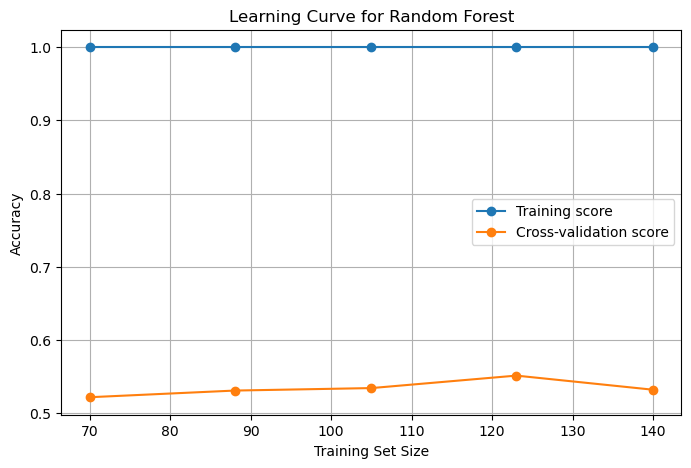

In [559]:
#Learning Curve
train_sizes, train_scores, test_scores = learning_curve(
    RandomForestClassifier(random_state=42),
    X, y,
    train_sizes=np.linspace(0.1, 0.2, 5),
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    shuffle=True,
    random_state=42
)

train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_scores_mean, 'o-', label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', label="Cross-validation score")
plt.title("Learning Curve for Random Forest")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid(True)
plt.show()


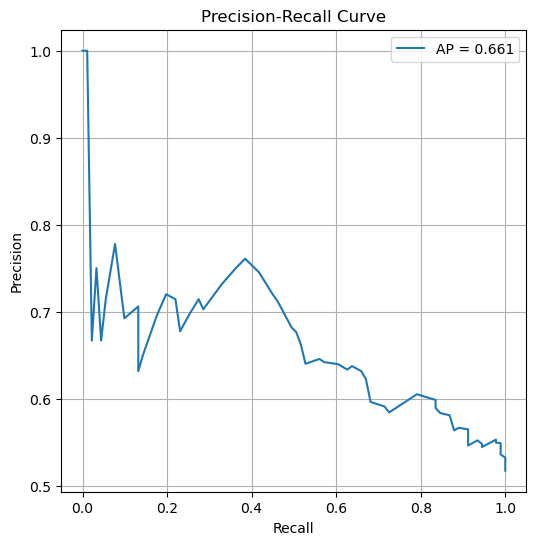

In [560]:
precision, recall, _ = precision_recall_curve(y_test, y_proba)
ap = average_precision_score(y_test, y_proba)

plt.figure(figsize=(6,6))
plt.plot(recall, precision, label=f"AP = {ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()

#### Hyper-parameter tuning RF binary approach model 

In [561]:
test_sizes = [0.2]
split_results = []

# Define a small parameter grid for quick search (expand for serious tuning!)
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

for test_size in test_sizes:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=42
    )

    # Baseline model
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Test size: {test_size:.2f}, Baseline Accuracy: {acc:.4f}")

    # Hyperparameter tuning
    grid = GridSearchCV(
        RandomForestClassifier(random_state=42),
        param_grid,
        cv=5,           
        n_jobs=-1,
        verbose=0
    )
    grid.fit(X_train, y_train)
    y_pred_tuned = grid.predict(X_test)
    acc_tuned = accuracy_score(y_test, y_pred_tuned)
    print(f"Test size: {test_size:.2f}, Tuned Accuracy: {acc_tuned:.4f}, Best Params: {grid.best_params_}")

    split_results.append((test_size, acc, acc_tuned, grid.best_params_))


Test size: 0.20, Baseline Accuracy: 0.6250
Test size: 0.20, Tuned Accuracy: 0.6136, Best Params: {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 400}


In [562]:
# 1. Get best model from GridSearchCV
best_rf = grid.best_estimator_
print(f"Best parameters: {grid.best_params_}")
# 2. Predict on test set
y_pred = best_rf.predict(X_test)
y_proba = best_rf.predict_proba(X_test)[:, 1]

Best parameters: {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 400}


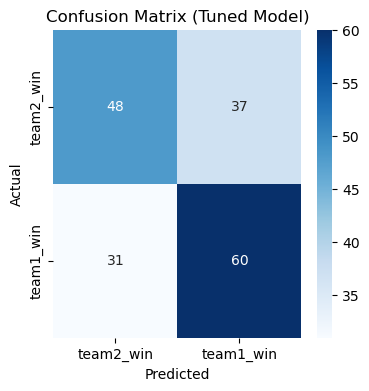

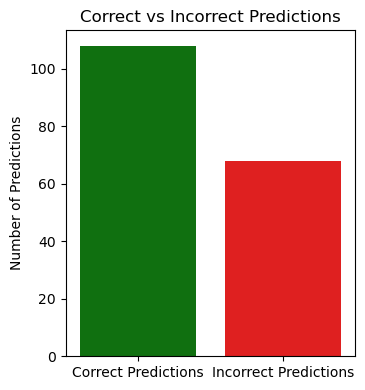

In [563]:
# 3. Confusion Matrix and Bar Plot
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['team2_win', 'team1_win'], 
            yticklabels=['team2_win', 'team1_win'])
plt.title("Confusion Matrix (Tuned Model)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

tn, fp, fn, tp = cm.ravel()
correct = tp + tn
incorrect = fp + fn
# Plot bar chart
plt.figure(figsize=(3.75, 4))
sns.barplot(x=["Correct Predictions", "Incorrect Predictions"], y=[correct, incorrect], palette=["green", "red"])
plt.title("Correct vs Incorrect Predictions")
plt.ylabel("Number of Predictions")
plt.tight_layout()
plt.show()


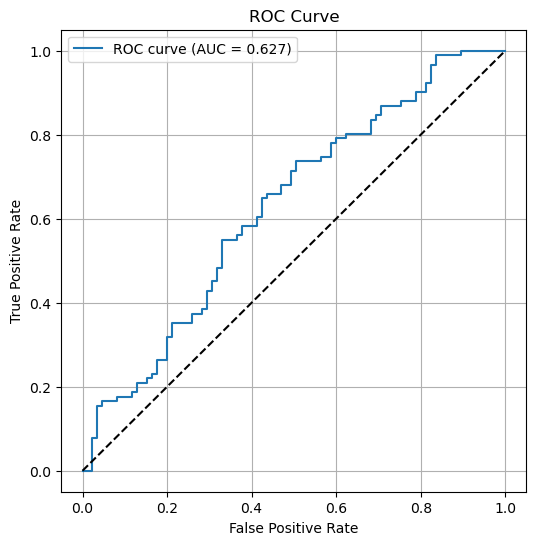

In [564]:
# 4. ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


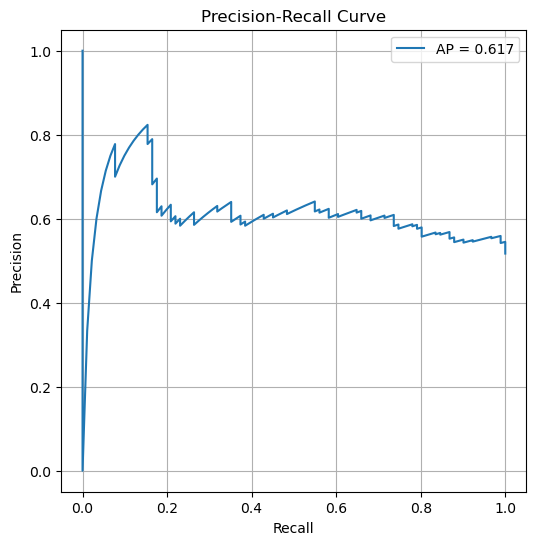

In [565]:
# 5. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)
ap = average_precision_score(y_test, y_proba)
plt.figure(figsize=(6,6))
plt.plot(recall, precision, label=f"AP = {ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()

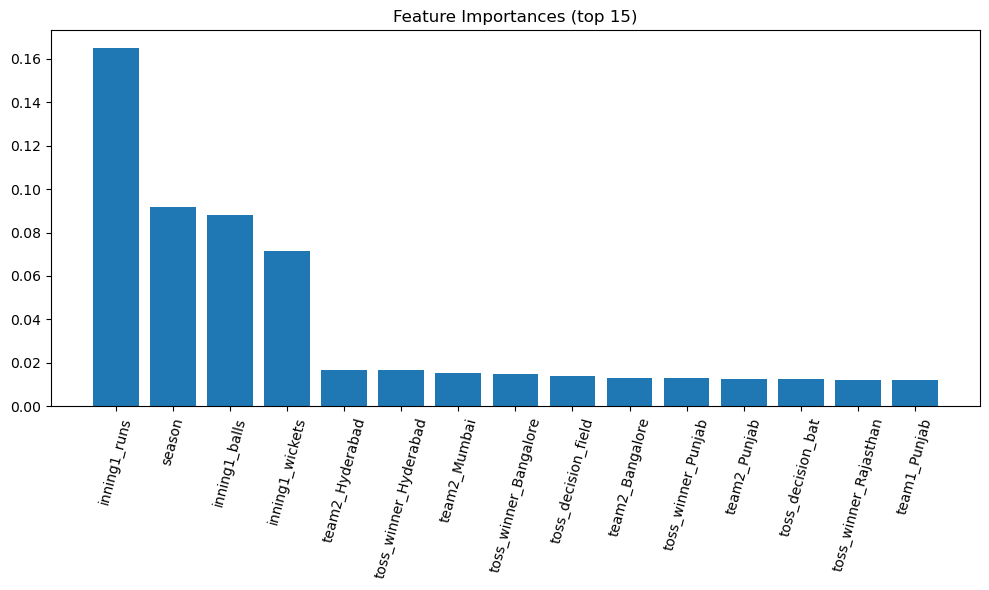

In [566]:
# 6. Feature Importance
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X_test.columns

plt.figure(figsize=(10,6))
plt.title("Feature Importances (top 15)")
plt.bar(range(15), importances[indices][:15], align="center")
plt.xticks(range(15), [feature_names[i] for i in indices[:15]], rotation=75)
plt.tight_layout()
plt.show()

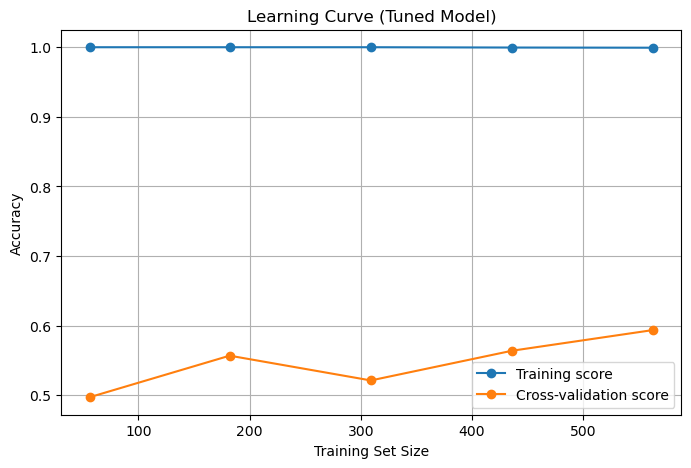

In [567]:
# 7. Learning Curve
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    best_rf, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 5), cv=5, scoring='accuracy', n_jobs=-1, shuffle=True, random_state=42
)
plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_scores.mean(axis=1), 'o-', label="Training score")
plt.plot(train_sizes, test_scores.mean(axis=1), 'o-', label="Cross-validation score")
plt.title("Learning Curve (Tuned Model)")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

In [568]:

# 8. Classification Report as DataFrame
report = classification_report(y_test, y_pred, target_names=['team2_win', 'team1_win'], output_dict=True)
report_df = pd.DataFrame(report).transpose().round(3)
display(report_df)  



,precision,recall,f1-score,support
team2_win,0.608,0.565,0.585,85.000
team1_win,0.619,0.659,0.638,91.000
accuracy,0.614,0.614,0.614,0.614
macro avg,0.613,0.612,0.612,176.000
weighted avg,0.613,0.614,0.613,176.000


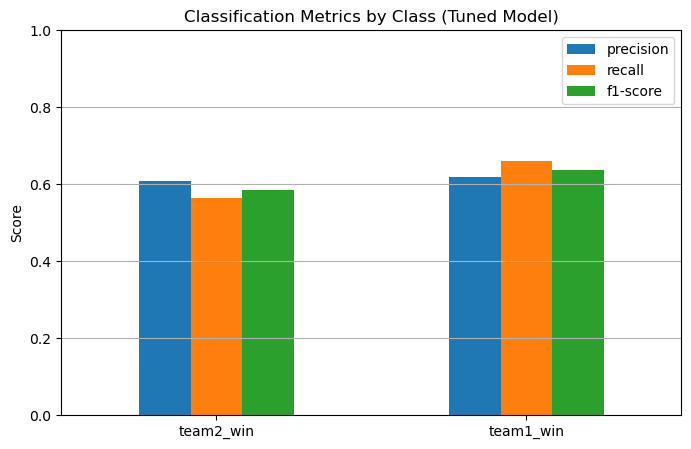

In [569]:
# 9. Bar Plot of classification metrics
plot_df = report_df.loc[['team2_win', 'team1_win'], ['precision', 'recall', 'f1-score']]
plot_df.plot(kind='bar', figsize=(8, 5))
plt.title('Classification Metrics by Class (Tuned Model)')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

#### Comparision between Untuned and Tuned model

=== Base Model Metrics ===
Accuracy: 0.625
ROC AUC: 0.6699418228829993
              precision    recall  f1-score   support

   team2_win       0.61      0.61      0.61        85
   team1_win       0.64      0.64      0.64        91

    accuracy                           0.62       176
   macro avg       0.62      0.62      0.62       176
weighted avg       0.62      0.62      0.62       176


=== Tuned Model Metrics ===
Accuracy: 0.6136363636363636
ROC AUC: 0.6270200387847447
              precision    recall  f1-score   support

   team2_win       0.61      0.56      0.59        85
   team1_win       0.62      0.66      0.64        91

    accuracy                           0.61       176
   macro avg       0.61      0.61      0.61       176
weighted avg       0.61      0.61      0.61       176



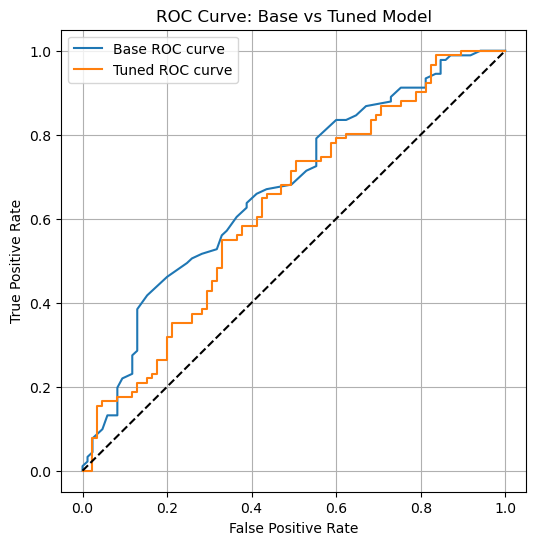

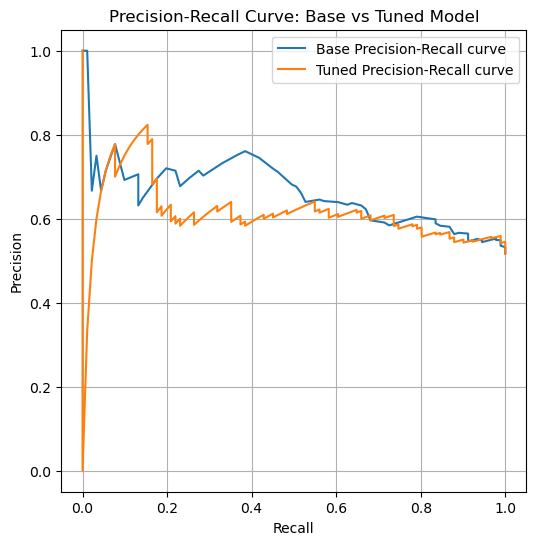

In [570]:
# 1. Fit base model (default hyperparameters)
base_rf = RandomForestClassifier(random_state=42)
base_rf.fit(X_train, y_train)
y_pred_base = base_rf.predict(X_test)
y_proba_base = base_rf.predict_proba(X_test)[:, 1]

# 2. Get tuned model predictions
tuned_rf = grid.best_estimator_
y_pred_tuned = tuned_rf.predict(X_test)
y_proba_tuned = tuned_rf.predict_proba(X_test)[:, 1]

# 3. Print main metrics
print("=== Base Model Metrics ===")
print("Accuracy:", accuracy_score(y_test, y_pred_base))
print("ROC AUC:", roc_auc_score(y_test, y_proba_base))
print(classification_report(y_test, y_pred_base, target_names=['team2_win', 'team1_win']))

print("\n=== Tuned Model Metrics ===")
print("Accuracy:", accuracy_score(y_test, y_pred_tuned))
print("ROC AUC:", roc_auc_score(y_test, y_proba_tuned))
print(classification_report(y_test, y_pred_tuned, target_names=['team2_win', 'team1_win']))

# 4. Plot ROC curves together
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr_base, tpr_base, _ = roc_curve(y_test, y_proba_base)
fpr_tuned, tpr_tuned, _ = roc_curve(y_test, y_proba_tuned)

plt.figure(figsize=(6,6))
plt.plot(fpr_base, tpr_base, label='Base ROC curve')
plt.plot(fpr_tuned, tpr_tuned, label='Tuned ROC curve')
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: Base vs Tuned Model")
plt.legend()
plt.grid(True)
plt.show()
# 5. Plot Precision-Recall curves together
precision_base, recall_base, _ = precision_recall_curve(y_test, y_proba_base)
precision_tuned, recall_tuned, _ = precision_recall_curve(y_test, y_proba_tuned)
plt.figure(figsize=(6,6))
plt.plot(recall_base, precision_base, label='Base Precision-Recall curve')
plt.plot(recall_tuned, precision_tuned, label='Tuned Precision-Recall curve')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve: Base vs Tuned Model")
plt.legend()
plt.grid(True)
plt.show()



In [571]:
# Suppose your GridSearchCV object is called 'grid'
print("Best parameters found by GridSearchCV:")
print(grid.best_params_)

# (Optional) Print the best model itself
print("\nBest Random Forest model:")
print(grid.best_estimator_)

Best parameters found by GridSearchCV:
{'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 400}

Best Random Forest model:
RandomForestClassifier(bootstrap=False, max_depth=20, min_samples_split=5,
                       n_estimators=400, random_state=42)


#### Cross Validation Report - to verify the model accuracy

In [572]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Baseline model
baseline_rf = RandomForestClassifier(random_state=42)
cv_scores_baseline = cross_val_score(baseline_rf, X, y, cv=5, scoring='accuracy')
print("Baseline Model Cross-Validated Accuracy: {:.2f}% ± {:.2f}%".format(
    cv_scores_baseline.mean() * 100, cv_scores_baseline.std() * 100))

# Tuned model from GridSearchCV
tuned_rf = grid.best_estimator_
cv_scores_tuned = cross_val_score(tuned_rf, X, y, cv=5, scoring='accuracy')
print("Tuned Model Cross-Validated Accuracy: {:.2f}% ± {:.2f}%".format(
    cv_scores_tuned.mean() * 100, cv_scores_tuned.std() * 100))


Baseline Model Cross-Validated Accuracy: 53.07% ± 7.54%
Tuned Model Cross-Validated Accuracy: 52.73% ± 7.21%
